 # Step 1: Importing Libraries and Dataset

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVC
from sklearn.metrics import *

import warnings
warnings.filterwarnings('ignore')

 # Step 2: Load and Explore the Dataset

In [168]:
df = pd.read_csv(r'/content/train (1).csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [169]:
df.shape

(913000, 4)

In [128]:
# Let's check which column of the dataset contains which type of data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [129]:
# As per the above information regarding the data in each column we can observe that there are no null values

df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


# Step 3: Feature Engineering

In [130]:
# There are times when multiple features are provided in the same feature or we have to derive some features from the existing ones.
#We will also try to include some extra features in our dataset so, that we can derive some interesting insights from the data we have.
# Also if the features derived are meaningful then they become a deciding factor in increasing the model's accuracy significantly.

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year.astype(int)
df['month'] = df['date'].dt.month.astype(int)
df['day'] = df['date'].dt.day.astype(int)

df

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5
...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12,27
912996,2017-12-28,10,50,59,2017,12,28
912997,2017-12-29,10,50,74,2017,12,29
912998,2017-12-30,10,50,62,2017,12,30


Whether it is a weekend or a weekday must have some effect on the requirements to fulfill the demands.

In [131]:
from datetime import datetime

def weekday_weekend(year,month,day):
  d = datetime(year,month,day)
  return 1 if d.weekday() > 4 else 0

df['weekend'] = df.apply(lambda x: weekday_weekend(x['year'],x['month'],x['day']), axis = 1)
df

,date,store,item,sales,year,month,day,weekend
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,1
...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12,27,0
912996,2017-12-28,10,50,59,2017,12,28,0
912997,2017-12-29,10,50,74,2017,12,29,0
912998,2017-12-30,10,50,62,2017,12,30,1


In [132]:
# It would be nice to have a column which can indicate whether there was any holiday on a particular day or not.

from datetime import date
import holidays

indian_holidays = holidays.country_holidays('IN')
df['holidays'] = df['date'].apply(lambda x: 1 if x in indian_holidays else 0)
df

,date,store,item,sales,year,month,day,weekend,holidays
0,2013-01-01,1,1,13,2013,1,1,0,0
1,2013-01-02,1,1,11,2013,1,2,0,0
2,2013-01-03,1,1,14,2013,1,3,0,0
3,2013-01-04,1,1,13,2013,1,4,0,0
4,2013-01-05,1,1,10,2013,1,5,1,0
...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12,27,0,0
912996,2017-12-28,10,50,59,2017,12,28,0,0
912997,2017-12-29,10,50,74,2017,12,29,0,0
912998,2017-12-30,10,50,62,2017,12,30,1,0


We want to get an idea of which months are "farthest" and "closest" because months are inherently cyclical, not linear.

Here's why this understanding, and the use of sine and cosine transformations, is crucial, especially in the context of machine learning:

1. The Problem with Linear Representation:

 * If you represent months as simple numbers (1 for January, 2 for February, ..., 12 for December), a machine learning model might interpret these numbers linearly.
 * For example, it would see the "distance" between December (12) and January (1) as 12 - 1 = 11. This is the largest possible linear distance.
 * However, in reality, January immediately follows December. They are the closest months in a cyclical sense.
 * Similarly, July (7) is "far" from January (1) linearly (7 - 1 = 6), and it's also cyclically "opposite" January.

2. How Sine and Cosine Solve This:

 * By transforming months into their sine (m1) and cosine (m2) components, you map them onto a unit circle.
 * On this circle:
    * Months that are cyclically close (like December and January) will have coordinate pairs (m2, m1) that are geometrically close to each other on the circle.
    * Months that are cyclically far or opposite (like January and July) will have coordinate pairs that are geometrically far apart on the circle.

3.Benefits for Machine Learning Models:

 * Correctly captures relationships: Models can now understand that January and December are related and close, while January and July are distinct and opposite.
 * Avoids misinterpretations: Without this transformation, a model might incorrectly learn that there's a huge difference between December and January, which could lead to poor predictions or insights for events that span across the year-end.
 * Improves model performance: For tasks where the time of year is important (e.g., predicting sales, energy consumption, or weather patterns), providing these cyclical features helps the model better capture seasonal trends and make more accurate predictions.

In [133]:
 # Now, let's add some cyclical features.

df['m1'] = np.sin(2 * np.pi * df['month']/12)

df['m2'] = np.cos(2 * np.pi * df['month']/12)

df

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0,5.000000e-01,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0,5.000000e-01,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0,5.000000e-01,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0,5.000000e-01,0.866025
4,2013-01-05,1,1,10,2013,1,5,1,0,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12,27,0,0,-2.449294e-16,1.000000
912996,2017-12-28,10,50,59,2017,12,28,0,0,-2.449294e-16,1.000000
912997,2017-12-29,10,50,74,2017,12,29,0,0,-2.449294e-16,1.000000
912998,2017-12-30,10,50,62,2017,12,30,1,0,-2.449294e-16,1.000000


In [134]:
# Let's have a column whose value indicates which day of the week it is.

In [135]:
def which_day(year,month,day):
  d = datetime(year,month,day)
  return d.weekday()

df['weekday'] = df.apply(lambda x: which_day(x['year'],x['month'],x['day']), axis = 1)
df

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0,5.000000e-01,0.866025,1
1,2013-01-02,1,1,11,2013,1,2,0,0,5.000000e-01,0.866025,2
2,2013-01-03,1,1,14,2013,1,3,0,0,5.000000e-01,0.866025,3
3,2013-01-04,1,1,13,2013,1,4,0,0,5.000000e-01,0.866025,4
4,2013-01-05,1,1,10,2013,1,5,1,0,5.000000e-01,0.866025,5
...,...,...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12,27,0,0,-2.449294e-16,1.000000,2
912996,2017-12-28,10,50,59,2017,12,28,0,0,-2.449294e-16,1.000000,3
912997,2017-12-29,10,50,74,2017,12,29,0,0,-2.449294e-16,1.000000,4
912998,2017-12-30,10,50,62,2017,12,30,1,0,-2.449294e-16,1.000000,5


In [136]:
# Now let's remove the columns which are not useful for us.

df.drop('date',axis = 1, inplace = True)

In [137]:
# There may be some other relevant features as well which can be added to this dataset but let's try to build a build with these ones and try to extract some insights as well.

 # Step 4: Exploratory Data Analysis

EDA analyzes the data using visual techniques. It is used to discover trends, and patterns or to check assumptions with the help of statistical summaries and graphical representations.  We have added some features to our dataset using some assumptions.

In [138]:
# Now let's check the unique values in the store and item
print(df['store'].unique(), df['item'].unique())
print()
print(df['store'].nunique(), df['item'].nunique())

[ 1  2  3  4  5  6  7  8  9 10] [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]

10 50


In [139]:
 # From here we can conclude that there are 10 unique stores and they sell 50 different products.

Now, let's analyze the relationship between various features and sales performance by visualizing.


This process helps you visually understand how different features (like which store, which month, or whether it's a weekend) correlate with the average sales figures.

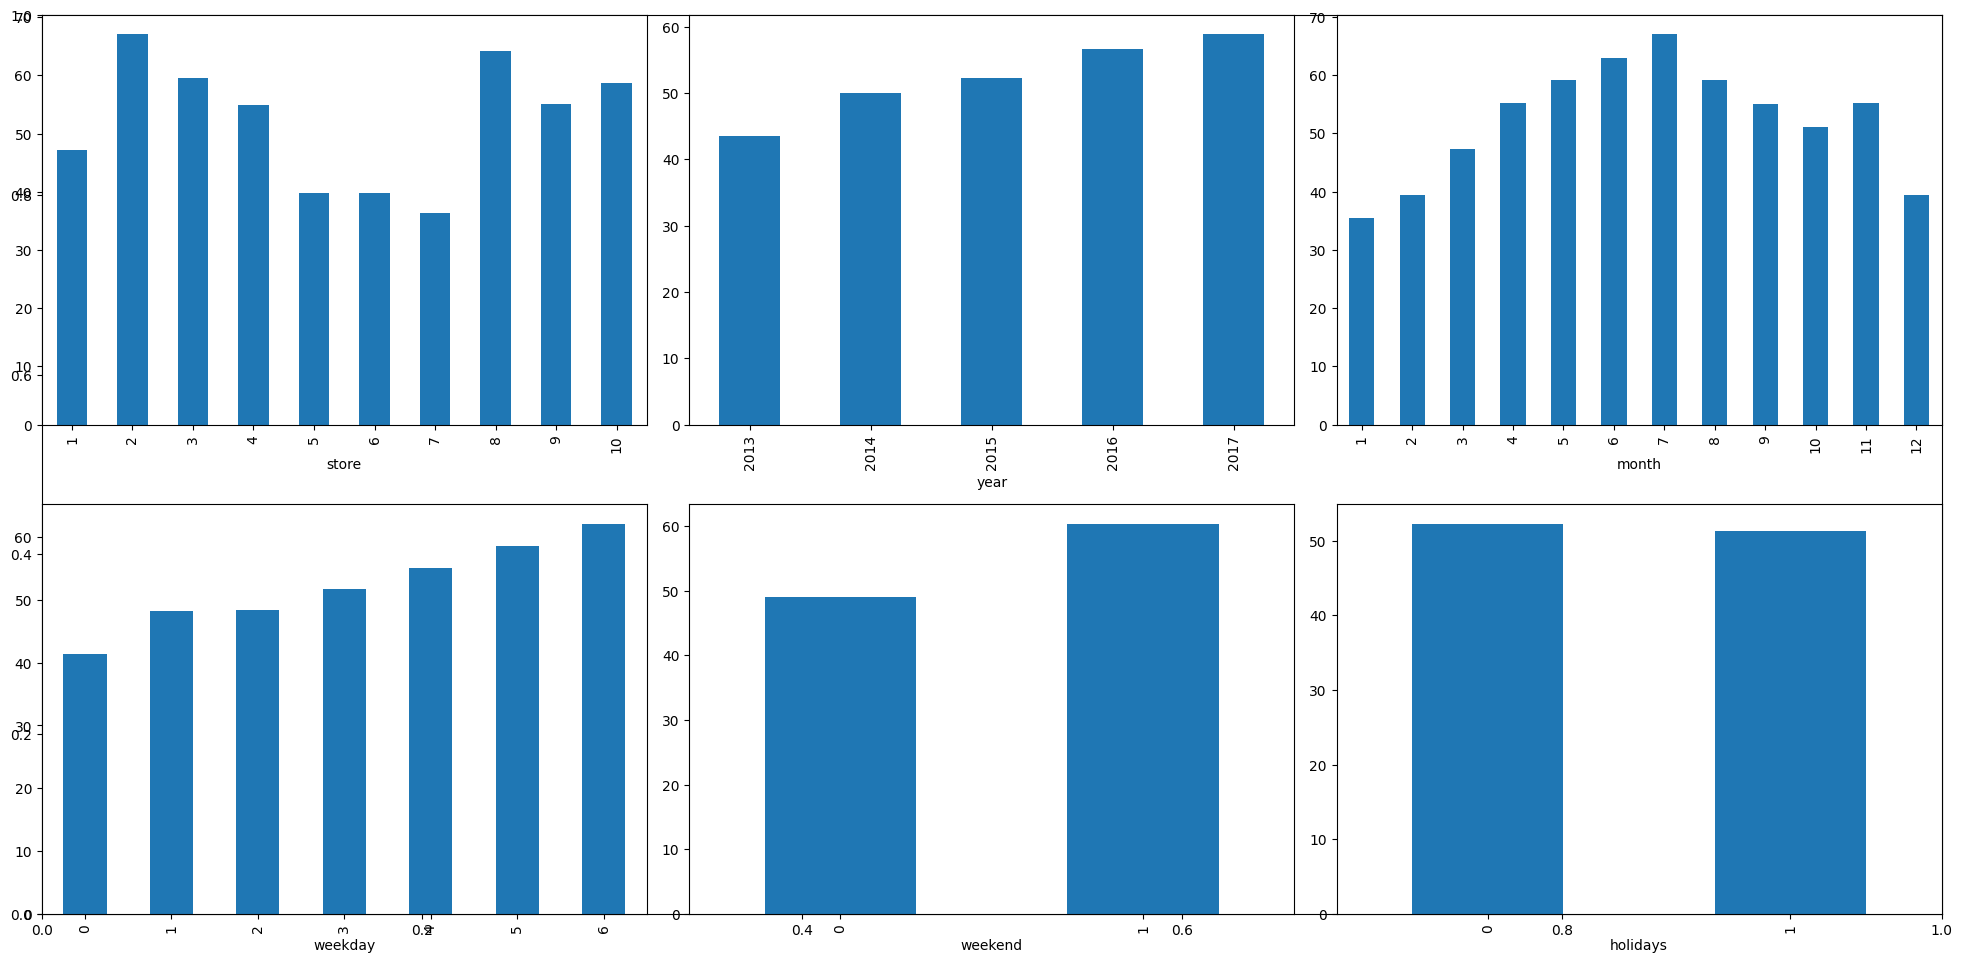

In [140]:
features = ['store','year','month','weekday','weekend','holidays']

plt.subplots(figsize = (20,10))
for i,col in enumerate(features):
  plt.subplot(2,3,i+1)
  df.groupby(by = col)['sales'].mean().plot.bar()
plt.tight_layout()
plt.show()

In [141]:
for col in features:
  catorgy_count = df[col].value_counts()
  print(f"Feature: {col}")
  print(catorgy_count)
  print()

Feature: store
store
1     91300
2     91300
3     91300
4     91300
5     91300
6     91300
7     91300
8     91300
9     91300
10    91300
Name: count, dtype: int64

Feature: year
year
2016    183000
2013    182500
2014    182500
2015    182500
2017    182500
Name: count, dtype: int64

Feature: month
month
1     77500
3     77500
7     77500
5     77500
12    77500
10    77500
8     77500
4     75000
9     75000
6     75000
11    75000
2     70500
Name: count, dtype: int64

Feature: weekday
weekday
1    130500
2    130500
3    130500
4    130500
5    130500
6    130500
0    130000
Name: count, dtype: int64

Feature: weekend
weekend
0    652000
1    261000
Name: count, dtype: int64

Feature: holidays
holidays
0    873500
1     39500
Name: count, dtype: int64



In [142]:
all_feature_stats = []

for col in features:
  mean_sales = df.groupby(col)['sales'].agg(['mean','count'])
  for category, row_data in mean_sales.iterrows():
    category_count = row_data['count']
    mean_sales_value = row_data['mean']
    all_feature_stats.append({
            'Feature': col,
            'Category': category,
            'Mean Sales': mean_sales_value,
            'Category Count': category_count_value
        })

result_df = pd.DataFrame(all_feature_stats)
result_df

,Feature,Category,Mean Sales,Category Count
0,store,1,47.268379,39500.0
1,store,2,67.033165,39500.0
2,store,3,59.530602,39500.0
3,store,4,54.902946,39500.0
4,store,5,39.770164,39500.0
5,store,6,39.733516,39500.0
6,store,7,36.363735,39500.0
7,store,8,64.142048,39500.0
8,store,9,55.049025,39500.0
9,store,10,58.709288,39500.0


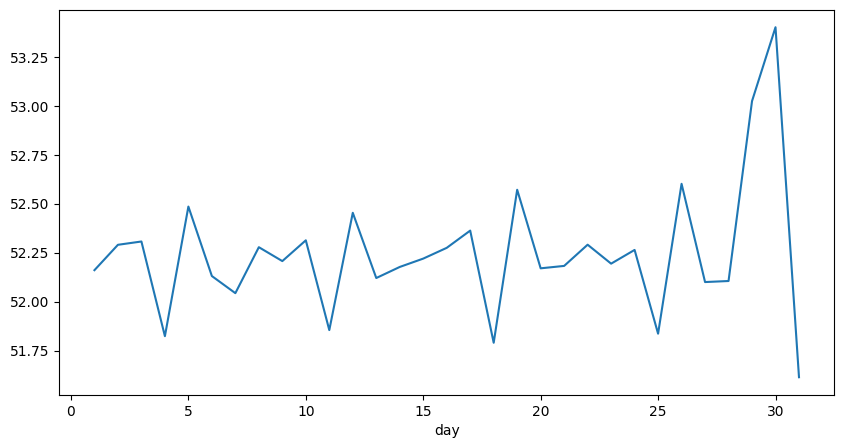

In [143]:
# Now let's check the variation of stock as the month closes to the end using line plot.
plt.figure(figsize = (10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()


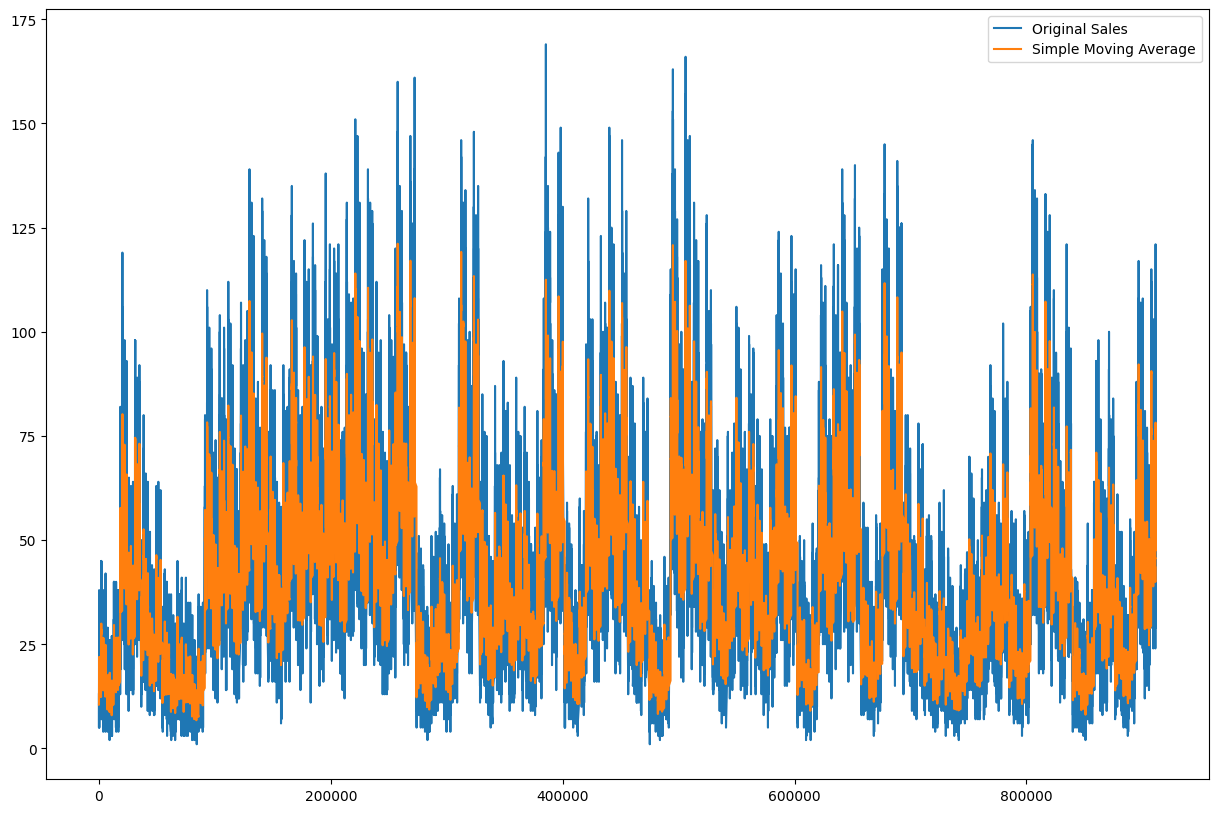

In [144]:
# Let's draw the simple moving average for 30 days period.
# Plotting simple moving average with help to smooth out short-term fluctuations and highlight longer-term trend or cycles in the data.

plt.figure(figsize=(15, 10))

# Calculating Simple Moving Average
# for a window period of 30 days

window_size = 30
data = df[df['year']==2013]
windows = data['sales'].rolling(window = window_size).mean()
sma = windows[29:]

plt.plot(data['sales'],label = 'Original Sales')
plt.plot(sma,label = 'Simple Moving Average')
plt.legend()
plt.show()

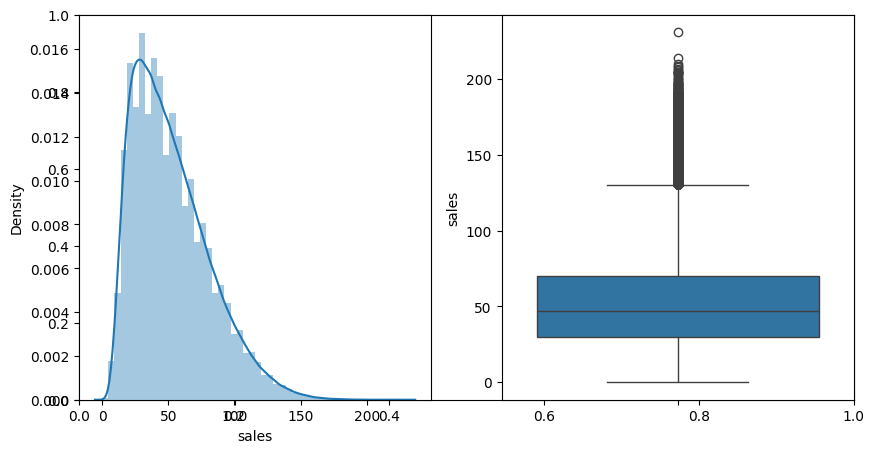

In [145]:
# As the data in the sales column is continuous let's check the distribution of it and check whether there are some outliers in this column or not.

plt.subplots(figsize = (10,5))
plt.subplot(1,2,1)
sns.distplot(df['sales'])

plt.subplot(1,2,2)
sns.boxplot(df['sales'])
plt.show()

We can observe that the distribution is right skewed and the dataset contains outliers.

Now, let's check the correlation between the features of the data and added a filter to identify only the highly correlated features. For computing the correlation between the features of the dataset

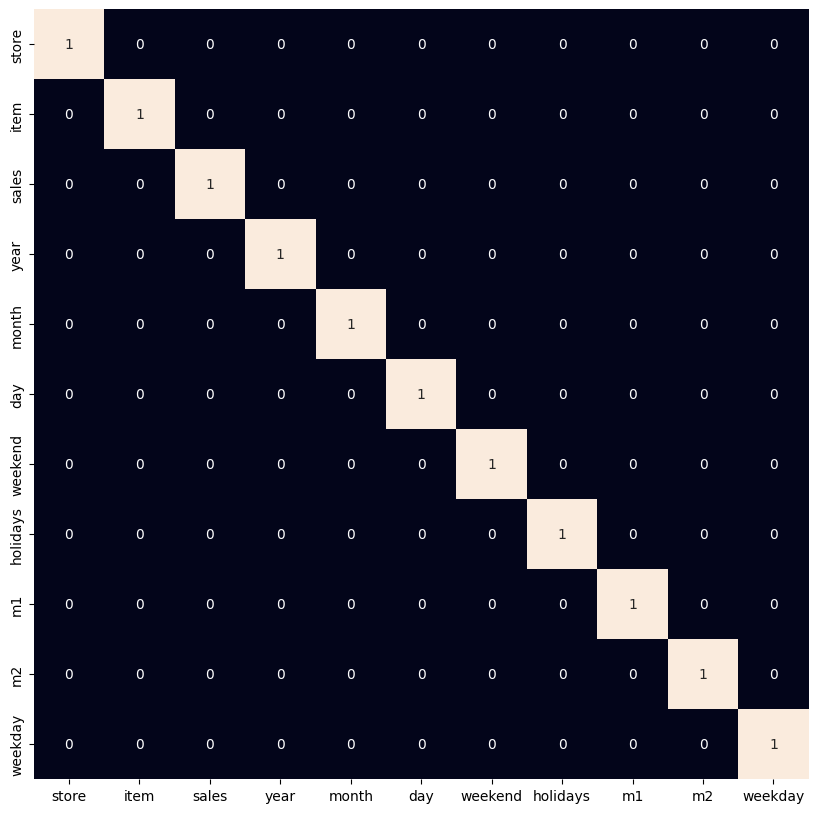

In [146]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr() > 0.8,annot = True,cbar = False)
plt.show()

In [147]:
# As we observed earlier let's remove the outliers which are present in the data.

In [148]:
df = df[df['sales'] < 140]

# Step 5: Model Training

In [149]:
# Now, we will separate the features and target variables and split them into training and the testing data by using which we will select the model which is performing best on the validation data.

In [162]:
features = df.drop(['sales','year'],axis = 1)
target = df['sales'].values

x_train,x_test,y_train,y_test = train_test_split(features,target,test_size = 0.05,random_state = 42)
x_train.shape,y_train.shape

((861170, 9), (861170,))

In [164]:
# Normalizing the data before feeding it into machine learning models helps us to achieve stable and fast training.

from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
x_train = scaler.fit_transform(x_train)
y_train = y_train.reshape(-1, 1)  # reshape to 2D
y_train = scaler.fit_transform(y_train)

We have split our data into training and validation data also the normalization of the data has been done. Now let's train machine learning models and select the best out of them using the validation dataset.

For this implementation, we have used Linear Regression, XGBoost, Lasso Regression and Ridge Regression.

In [175]:
model = [LinearRegression(),XGBRegressor(),Lasso(),Ridge()]

for i in range(4):
  model[i].fit(x_train,y_train)

  print(f'{model[i]} :')

  y_train_pred = model[i].predict(x_train)
  y_test_pred = model[i].predict(x_test)
  r2_test = r2_score(y_test,y_test_pred)
  r2_train = r2_score(y_train,y_train_pred)
  print('Training Error:',mean_squared_error(y_train,y_train_pred))
  print('Testing Error:',mean_squared_error(y_test,y_test_pred))
  print('R2 Score on Training Data:',r2_train)
  print('R2 Score on Testing Data:',r2_test)
  print()
  print()



LinearRegression() :
Training Error: 0.8615479740901735
Testing Error: 3450.2779041839776
R2 Score on Training Data: 0.1384520259098262
R2 Score on Testing Data: -3.5003795390708996


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) :
Training Error: 0.10729225316580836
Testing Error: 3310.88403320312